#Klasifikasi Jamur Menggunakan Genetic Algorithm dan ANN

- Muhamad Febrian Soambaton
- Wildan
- Amal
- Raihan


##Import Library, dataset, dan fungsi-fungsi:

###Library:

In [17]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files, drive

warnings.filterwarnings('ignore')
np.random.seed(69420)
random.seed(69420)

###Memasukkan Dataset:

In [18]:
df = pd.read_csv("mushrooms.csv")

###Fungsi-Fungsi:

In [19]:
########################

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))

    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions

def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

def mating_pool(pop, fitness, num_parents):
    print("pop shape")
    print(pop.shape)
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    print("looping berapa kali")
    print(offspring_size[0])

    print("parent shape")
    print(parents.shape)

    for k in range(offspring_size[0]):
        # 0, 1 | 1, 2 | 2, 3 | 3, 0

        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]

        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))

    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1) # kenapa uniform ? biar ga dapet nilai pengurangan/penjumlahan yang besar
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value

    return offspring_crossover

##############################

In [20]:
np.random.uniform(-1.0, 1.0, 1)

array([0.06218448])

###Membaca dataset:

##Pra-proses:

In [21]:
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv("mushrooms.csv")

# Now you can proceed with the rest of your code...
# For instance, the subsequent lines that handle encoding and handling missing values.

#Ambil target
target = df['class']

#Merubah missing value menjadi modus
df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)

#Merubah data kategorik kedalam bentuk angka
encoder = LabelEncoder()
df_encoded = df.iloc[:, 1:]
cols = df_encoded.columns.values
for col in cols:
    # print(df[col].unique())
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

target_encoded = encoder.fit_transform(target)

df_encoded.head()


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


##Klasifikasi:

In [22]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

#Parameter GA
solution_per_population = 8
num_parents_mating = 4
num_generations = 15

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):

    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1, size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

#Parameter penilaian
error_rate = []
accu_uyeh = []
best_outputs = []
accuracies = np.empty(shape=(num_generations))

# Pengujian model
for i in range(1,11):
  mutation_percent = i/10

  weights_mat = np.array(initial_weights)
  weights_vector = mat_to_vector(weights_mat)

  accuracies = np.empty(shape=(num_generations))
  for generation in tqdm(range(num_generations), desc="Processing mutation_percent = " + str(i/10), leave=False):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)

    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

  weights_mat = vector_to_mat(weights_vector, weights_mat)
  best_weights = weights_mat [0, :]
  acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
  error_rate.append(np.mean(predictions != y_train))
  accu_uyeh.append(acc)

#Plot
xDex = []
for i in range(1,11):
  xDex.append(i/10)

plt.plot(xDex, error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Mutation Percent')
plt.xlabel('Mutation Percent')
plt.ylabel('Error Rate')
plt.show()

Processing mutation_percent = 0.1:   7%|▋         | 1/15 [00:04<01:08,  4.86s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  13%|█▎        | 2/15 [00:10<01:10,  5.46s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  20%|██        | 3/15 [00:13<00:53,  4.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  27%|██▋       | 4/15 [00:16<00:42,  3.87s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  33%|███▎      | 5/15 [00:19<00:35,  3.52s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  40%|████      | 6/15 [00:23<00:30,  3.41s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  47%|████▋     | 7/15 [00:26<00:26,  3.33s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  53%|█████▎    | 8/15 [00:29<00:22,  3.18s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  60%|██████    | 9/15 [00:31<00:18,  3.01s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  67%|██████▋   | 10/15 [00:34<00:14,  2.94s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  73%|███████▎  | 11/15 [00:37<00:11,  2.95s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  80%|████████  | 12/15 [00:40<00:09,  3.02s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  87%|████████▋ | 13/15 [00:43<00:06,  3.02s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  93%|█████████▎| 14/15 [00:46<00:02,  2.93s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:   7%|▋         | 1/15 [00:06<01:30,  6.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  13%|█▎        | 2/15 [00:10<01:05,  5.07s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  20%|██        | 3/15 [00:13<00:48,  4.03s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  27%|██▋       | 4/15 [00:16<00:40,  3.66s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  33%|███▎      | 5/15 [00:19<00:35,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


KeyboardInterrupt: ignored

In [23]:
(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1])

(4, 11136)

In [24]:
weights_vector.shape

(8, 11136)

###Membuat model dengan mutation_percent terbaik:

In [25]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

# Buat model dengan mutation_percent 0.1
solution_per_population = 8
num_parents_mating = 4
num_generations = 20
mutation_percent = 0.1

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):

    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

# training
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)

    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

  5%|▌         | 1/20 [00:02<00:54,  2.85s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 10%|█         | 2/20 [00:05<00:52,  2.89s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 15%|█▌        | 3/20 [00:08<00:49,  2.90s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 20%|██        | 4/20 [00:11<00:48,  3.01s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 25%|██▌       | 5/20 [00:15<00:47,  3.14s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 30%|███       | 6/20 [00:18<00:46,  3.30s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 35%|███▌      | 7/20 [00:21<00:39,  3.07s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 40%|████      | 8/20 [00:24<00:36,  3.00s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 45%|████▌     | 9/20 [00:29<00:42,  3.84s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 50%|█████     | 10/20 [00:32<00:35,  3.57s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 55%|█████▌    | 11/20 [00:35<00:30,  3.34s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 60%|██████    | 12/20 [00:38<00:25,  3.18s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 65%|██████▌   | 13/20 [00:41<00:22,  3.15s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 70%|███████   | 14/20 [00:44<00:18,  3.11s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 75%|███████▌  | 15/20 [00:47<00:15,  3.18s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


KeyboardInterrupt: ignored

###Plot Fitnes setiap iterasinya:

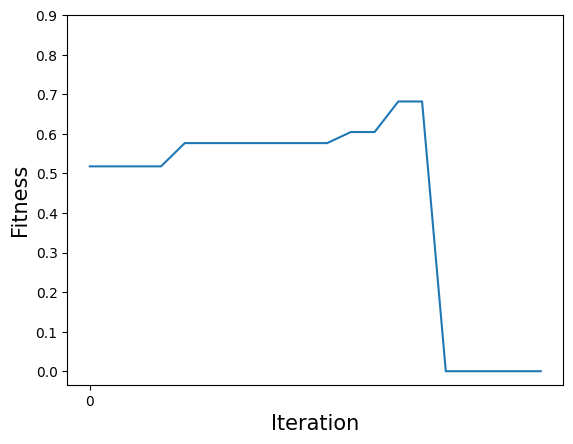

In [26]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

###Cunfusion Matrix & Classification Report:

In [27]:
print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))

[[2670  695]
 [1231 1903]]
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3365
           1       0.73      0.61      0.66      3134

    accuracy                           0.70      6499
   macro avg       0.71      0.70      0.70      6499
weighted avg       0.71      0.70      0.70      6499



##Prediksi data test

In [28]:
#Implementasi pada data test
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.699076923076923


###Cunfusion Matrix & Classification Report:

In [29]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[420 423]
 [ 66 716]]
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       843
           1       0.63      0.92      0.75       782

    accuracy                           0.70      1625
   macro avg       0.75      0.71      0.69      1625
weighted avg       0.75      0.70      0.69      1625

